Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.3315 - val_loss: 0.0976
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.2451 - val_loss: 0.0711
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1577 - val_loss: 0.0432
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0494 - val_loss: 0.0520
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0383 - val_loss: 0.0439
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0077 - val_loss: 0.0369
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0126 - val_loss: 0.0368
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0133 - val_loss: 0.0400
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0066 - val_loss: 0.0487
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0083 - val_loss: 0.0511
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0063 - val_loss: 0.0439
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0070 - val_loss: 0.03

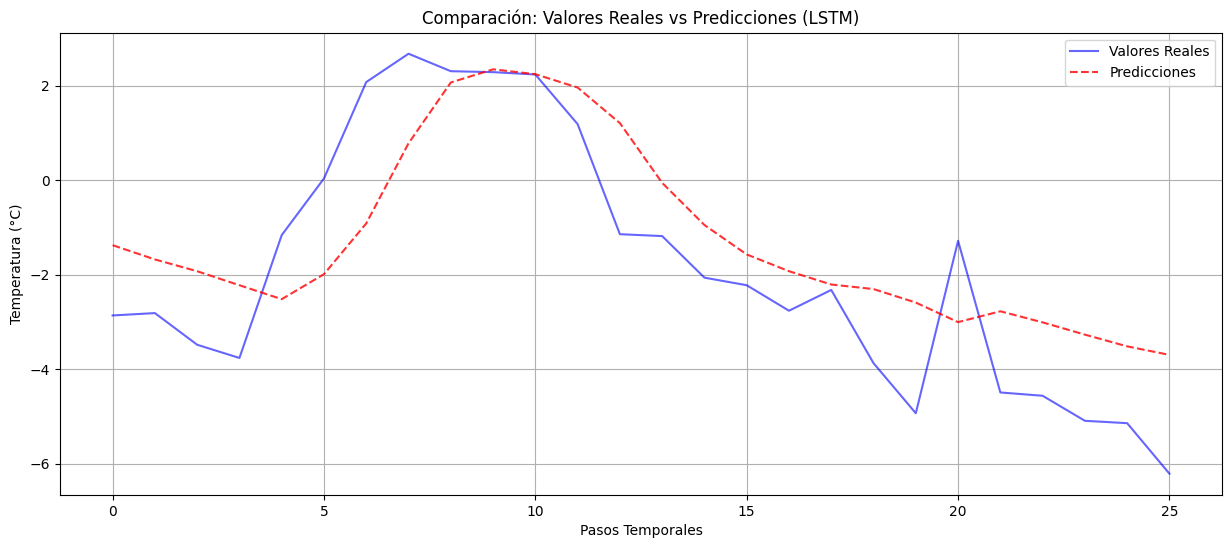

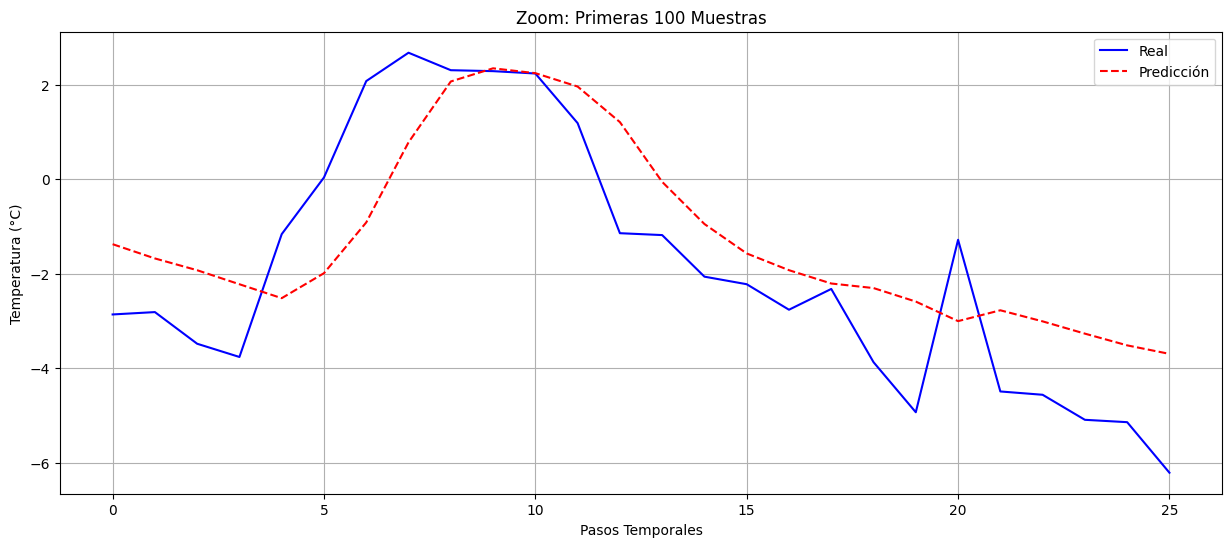

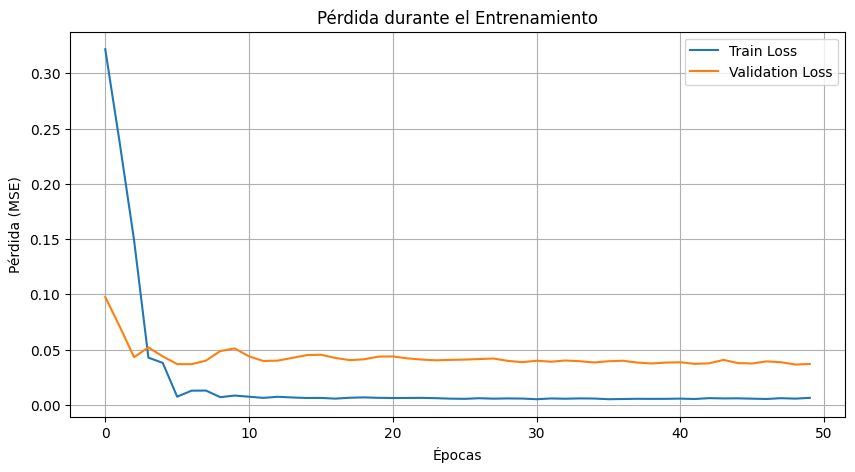

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Predicción: -0.61°C
Valor real: -2.86°C


In [16]:
# Proyecto 1: Redes Neuronales Recurrentes (LSTM)
# Predicción de series temporales - Temperatura Ambiental
# Dataset: https://www.kaggle.com/datasets/budincsevity/szeged-weather
# Balam Kaled Moreno Amaro

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

#Cargamos y limpiamos los datos
ruta=r"C:\Users\bakam\Downloads\Diplomado\weather_sample.csv"
df = pd.read_csv(ruta)

# Cambiamos el formato de la fecha para que sea posible la lectura de datos
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)  
df = df[['Formatted Date', 'Temperature (C)']]
df = df.set_index('Formatted Date').sort_index()  # Ordenamos por fecha
df = df.resample('h').mean().dropna() 

# Normalizamos los datos con la funcion MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Creamos secuencias temporales para tener ventanas de datos
def crear_secuencias(data, sec_length):
    X, y = [], []
    #En X estaran los valores consecutivos de la temperatura, en este caso 72 horas, por otra parte en Y se almacenara el valor a predecir
    for i in range(len(data)-sec_length-1):
        X.append(data[i:(i+sec_length), 0])
        y.append(data[i+sec_length, 0])
    return np.array(X), np.array(y)

#Se elige un periodo de tres dias (72 horas) para asegurarnos de captar patrones diarios
SEC_LENGTH = 72  
X, y = crear_secuencias(scaled_data, SEC_LENGTH)

# Dividimos los datos de entrenamiento y los datos de prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reformatear para LSTM [muestras, pasos temporales, características]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construimos el modelo LSTM
modelo = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(50, activation='relu', return_sequences=True), #Elegimos 50 neuronas y el modelo relu para evitar algun sobreajuste
    Dropout(0.2), #Desactivamos 20% de las neuronas
    LSTM(30, activation='relu'), #Segunda capa con 0 nueronas y modelo relu 
    Dense(1) #Acabamos con una neurona que corresponde a un valor numerico (Prediccion)
])

#Eleccion de optimizador Adam
optimizer = Adam(learning_rate=0.001)
modelo.compile(optimizer=optimizer, loss='mse')

# Entrenamiento de los datos
history = modelo.fit(
    X_train, y_train,
    epochs=50, #Elegimos 50 iteracciones completas sobre los datos
    batch_size=32, #Muestras por cada lote
    validation_data=(X_test, y_test),
    verbose=1
)

#Predicciones
y_pred = model.predict(X_test)

y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler.inverse_transform(y_pred)

#Temperatura reales vs predicciones
plt.figure(figsize=(15, 6))
plt.plot(y_test_real, label='Valores Reales', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicciones', color='red', linestyle='--', alpha=0.8)
plt.title('Comparación: Valores Reales vs Predicciones')
plt.xlabel('Pasos Temporales')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

#Perdida en el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Prediccion de la temperatura (ejemplo)
test_sample = X_test[0].reshape(1, SEQ_LENGTH, 1)
prediccion = modelo.predict(test_sample)
predic_temp = scaler.inverse_transform(prediccion)[0][0]
real_temp = scaler.inverse_transform(y_test[0].reshape(-1, 1))[0][0]

print(f"Predicción: {predic_temp:.2f}°C")
print(f"Valor real: {real_temp:.2f}°C")